# Bagging with Selected Features

Why bagging? It seems to be one of the best models there is. Time used isn't that long, so it might be a good starting point. 

In [18]:
selected_features = ['attendance', 'home_team_avg_att_last_year', 'day_Saturday', 'team2_pre_win',  'team2_pre_win_pct', 'day_Friday', 'season_type_post', 'day_Sunday', 'team2_pre_win', 'team1_pre_win', 'temperature', 'salary-1500', 'salary-800-1500', 'salary-500-800', 'team2_streak']
selected_home_teams = ['LAD', 'STL', 'LAA', 'HOU']
selected_players = [
    'Nick-Markakis', 
    'Ervin-Santana',
    'Bryce-Harper',
    'Ryan-Zimmerman', 
    'Patrick-Corbin',
    'Freddie-Freeman', 
    'Manny-Machado',
    'Josh-Harrison',
    'Mookie-Betts',
    'J.D.-Martinez',
    'Mitch-Moreland',
    'Scooter-Gennett',
    'Trevor-Bauer',
    'Yu-Darvish',
    'Starlin-Castro',
    'Pat-Neshek',
    'Dexter-Fowler',
    'Joc-Pederson',
    'Dansby-Swanson',
    'Bryce-Harper'
]

selected_home_teams = ['team2_name_' + team_name for team_name in selected_home_teams]

final_selected_features = selected_features + selected_home_teams + selected_players
len(final_selected_features)

39

Some thoughts:

+ Maybe some of the features can be combined, for example `day_Friday`, `day_Saturday`, and `day_Sunday` can be listed as `day_weekend`
+ PCA against all players
+ Can probably still try to group stadium into three levels

In [19]:
import numpy as np
import pandas as pd

## Prepocessing

In [20]:
raw_test_df = pd.read_csv('../../statistical-learning/processed_test.csv')
raw_train_df = pd.read_csv('../../statistical-learning/processed_training.csv')

In [21]:
# still need to one hot team1_name and team2_name

raw_train_df = pd.get_dummies(raw_train_df, columns=['team1_name', 'team2_name', 'season_type'])
raw_test_df = pd.get_dummies(raw_test_df, columns=['team1_name', 'team2_name', 'season_type'])

# drop columns: venue, start_hour
raw_train_df = raw_train_df.drop(columns=['venue', 'start_hour'], axis=1)
raw_test_df = raw_test_df.drop(columns=['venue', 'start_hour'], axis=1)

In [22]:
train_cols = raw_train_df.columns
raw_test_df = raw_test_df[train_cols].copy()

In [23]:
raw_train_df = raw_train_df[final_selected_features]
raw_test_df = raw_test_df[final_selected_features]

In [24]:
X, y = raw_train_df.drop(columns=['attendance'], axis=1), raw_train_df['attendance']

## Model Building

### Model Evaluation Function

In [25]:
# MSE, RMSE, MAE, MAPE

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def measure_model(y_true, y_pred, verbose=True, title=''):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    if verbose:
        print(f'''{"="*10} {title} {"="*10}
MSE: {mse:.2f}
RMSE: {rmse:.2f}
MAE: {mae:.2f}
MAPE: {mape:.2f}''')

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

In [26]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, cross_validate

### Simple Bagging Model

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bagging Regressor
regr = BaggingRegressor(n_estimators=10, random_state=42).fit(X_train, y_train)
y_pred_simple = regr.predict(X_test)

_ = measure_model(y_test, y_pred_simple, title='Simple Bagging Regressor')

========== Simple Bagging Regressor ==========
MSE: 24190088.83
RMSE: 4918.34
MAE: 3654.96
MAPE: 0.14


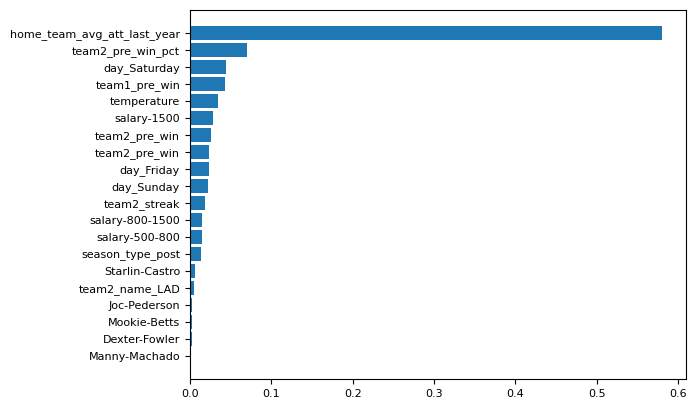

In [28]:
# matplotlib
import matplotlib.pyplot as plt

feature_importances = np.mean([
    tree.feature_importances_ for tree in regr.estimators_
], axis=0)

num_features = 20

indices = np.argsort(feature_importances)[::-1][:num_features]

fig, ax = plt.subplots()
ax.barh(range(num_features), feature_importances[indices][::-1])
ax.set_yticks(range(num_features))
_ = ax.set_yticklabels(np.array(X.columns)[indices][::-1])
# font size
plt.rcParams.update({'font.size': 8})

### Hyperparameter Tuning

In [29]:
# skf = StratifiedKFold(n_splits=5)
scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']
n_estimators_grid = np.geomspace(5, 500, 10, endpoint=True, dtype=int) # 10 numbers between 5 and 500
n_estimators_dict = {}

for n_estimators in n_estimators_grid:
    regr = BaggingRegressor(n_estimators=n_estimators, random_state=42)
    results = cross_validate(regr, X, y, cv=5, scoring=scoring, return_train_score=True)

    metric_dict = {}
    metric_dict['MSE'] = results['test_neg_mean_squared_error'].mean()
    metric_dict['RMSE (Train)'] = results['train_neg_root_mean_squared_error'].mean()
    metric_dict['RMSE'] = results['test_neg_root_mean_squared_error'].mean()
    metric_dict['MAE'] = results['test_neg_mean_absolute_error'].mean()
    metric_dict['MAPE'] = results['test_neg_mean_absolute_percentage_error'].mean()
    metric_dict['fit_time'] = results['fit_time'].mean()
    metric_dict['score_time'] = results['score_time'].mean()

    n_estimators_dict[n_estimators] = metric_dict

### Use the best hyperparameters to train the model

In [30]:
metric_df = pd.DataFrame(n_estimators_dict).T.reset_index().rename(columns={'index': 'n_estimators'})
metric_df

,n_estimators,MSE,RMSE (Train),RMSE,MAE,MAPE,fit_time,score_time
0,5,-4.057570e+07,-2391.985976,-6361.241133,-4828.817115,-0.203032,0.241819,0.004404
1,8,-3.808902e+07,-2164.665715,-6160.997269,-4673.155858,-0.197452,0.384149,0.006606
2,13,-3.649003e+07,-1988.446264,-6030.918912,-4578.669143,-0.193145,0.617561,0.008808
3,23,-3.558136e+07,-1878.550860,-5956.929472,-4524.531530,-0.191702,1.080381,0.013813
4,38,-3.508489e+07,-1813.095486,-5916.686187,-4492.677701,-0.190313,1.784121,0.023021
5,64,-3.471949e+07,-1774.951194,-5885.476162,-4471.072689,-0.189688,2.987112,0.034231
6,107,-3.449108e+07,-1748.972910,-5866.310958,-4455.569986,-0.189255,4.992933,0.056051
7,179,-3.422405e+07,-1732.427054,-5844.061263,-4434.666001,-0.188487,8.343175,0.091283
8,299,-3.419455e+07,-1724.201982,-5841.988005,-4430.279533,-0.188270,13.899419,0.151137
9,500,-3.422620e+07,-1719.418094,-5844.403917,-4433.254300,-0.188416,23.218480,0.251028


In [32]:
best_grid = metric_df[abs(metric_df['RMSE']) == abs(metric_df['RMSE']).min()]
best_rmse = best_grid['RMSE'].values[0]
best_nest = best_grid['n_estimators'].values[0]

print(f'Best number of trees = {best_nest} with RMSE = {best_rmse}')

Best number of trees = 299 with RMSE = -5841.988004924209


In [33]:
regr = BaggingRegressor(n_estimators=best_nest, random_state=0).fit(X, y) # 299

In [38]:
# save model in YYYYMMDD format
from datetime import datetime
import pickle
 
regr_filename = f'{datetime.today().strftime("%Y%m%d")}_bagging_model_less_features_299.pkl'
pickle.dump(regr, open(regr_filename, 'wb'))

### Feature Importance

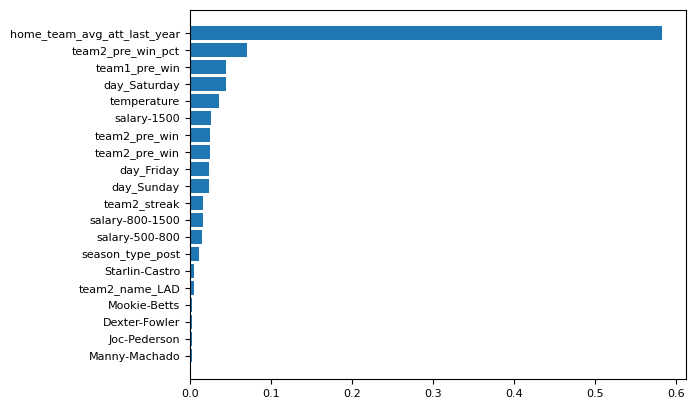

In [35]:
# matplotlib
import matplotlib.pyplot as plt

feature_importances = np.mean([
    tree.feature_importances_ for tree in regr.estimators_
], axis=0)

num_features = 20

indices = np.argsort(feature_importances)[::-1][:num_features]

fig, ax = plt.subplots()
ax.barh(range(num_features), feature_importances[indices][::-1])
ax.set_yticks(range(num_features))
_ = ax.set_yticklabels(np.array(X.columns)[indices][::-1])
# font size
plt.rcParams.update({'font.size': 8})

+ Should compare `day_weekend` with `day_weekday`
+ Only LAD stands out from other teams

## Model Evaluation

In [36]:
X_test, y_test = raw_test_df.drop(columns=['attendance'], axis=1), raw_test_df['attendance']

In [37]:
# read model
import pickle
regr = pickle.load(open('20221127_bagging_model_less_features_299.pkl', 'rb'))
y_pred = regr.predict(X_test)

# performance
test_performance = measure_model(y_test, y_pred, title='Bagging Regressor')

========== Bagging Regressor ==========
MSE: 47635628.02
RMSE: 6901.86
MAE: 5359.37
MAPE: 0.28


It turns out that with specific features selected, it still doesn't perform that well. 